In [1287]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
from scipy.linalg import sqrtm
import pandas as pd
np.random.seed(1234)

In [1380]:
#Muller Brown Potential and Gradient

def MB_potential(x,y):    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value
vMB_potential = np.vectorize(Muller_Brown_potential)

def grad_MB(x,y):
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dx = 0
    dy = 0
    for j in range(0, 4):
        dx += AA[j] *(2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        dy += AA[j] *(2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))* np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return dx, dy
vgrad_MB = np.vectorize(grad_MB)

def Hessian_MB(x,y):
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    dxx = 0
    dxy = 0
    dyy = 0
    for j in range(0, 4):
        Phi = AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
        alpha = (2*aa[j]*(x-XX[j])+bb[j]*(y-YY[j]))
        beta = (2*cc[j]*(y-YY[j])+bb[j]*(x-XX[j]))
        dxx += 2*aa[j]*Phi + alpha**2*Phi
        dxy += bb[j]*Phi + bb[j]*(y-YY[j])*beta*Phi
        dyy += 2*cc[j]*Phi + beta**2*Phi
        
    return dxx, dxy, dxy, dyy
vHessian_MB = np.vectorize(Hessian_MB)

In [1359]:
def affine_invariant_wd(N = 5000, learning_rate = 1e-4, mu = 0, sigma = 1):
    intervals = np.arange(1, 1e5, 20)
    #initialise variables (particles)
    dt = learning_rate
    C = sigma**2*np.identity(2)
    mean = np.array([0.2, 1.2])
    x,y = np.random.multivariate_normal(mean, C)
    #x = np.random.uniform(-1.5, 1.2)
    #y = np.random.uniform(-0.2, 2)
    points_x = [x]
    points_y = [y]
    
    beta = 10
    
    for i in trange(1, N+1):
        
        grad = grad_MB(x,y)
        
        dt
        dx,dy = - C@grad/beta*dt + np.sqrt(2)*sqrtm(C)@np.random.normal(0,dt,2)
        x += dx
        y += dy
        if i in intervals: 
            points_x.append(x)
            points_y.append(y)

        Z = np.random.multivariate_normal(mean, C, int(1e3))
        X = Z[:,0]
        Y = Z[:,1]
        Dx, Dy = vgrad_MB(X,Y)
        exp_m = np.array([np.mean(Dx), np.mean(Dy)])/beta
        
        Dxx, Dxy, Dyx, Dyy = vHessian_MB(X,Y)
        dxx = np.mean(Dxx)
        dxy = np.mean(Dxy)
        dyx = dxy
        dyy = np.mean(Dyy)
        exp_c = np.array([[dxx, dxy], [dyx, dyy]])/beta**2
        #update mean and covariance matrix
        mean = mean-C@exp_m*dt
        C = C + 2*C*dt-2*C@exp_c@C*dt
        print(x,y)
        
    return points_x, points_y, mean,C

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.19995352863253035 1.2007001866983882
0.19998063993491608 1.2007090380305225
0.1999841372947264 1.20073079500452
0.19998419375442025 1.2007271921184788
0.19998945156291031 1.2007341798134132
0.19995436099337205 1.2007092987992523
0.19993994388213054 1.2006959593657418
0.1999445588057694 1.2006954070384668
0.19993485312844497 1.2006897741392724
0.19994348308249543 1.2007068058899195
0.1999565804606308 1.2006894063783384
0.1999659364635564 1.2006892964133575
0.19994683121200932 1.2006883777353994
0.1999389939331212 1.200700502912864
0.19992944494412568 1.2007140494728465
0.1999439842329275 1.2007261721044549
0.1999136613946853 1.2007232226180449
0.19990978885934327 1.200705755248369
0.1998927404723649 1.2007024870786627
0.19986826728513063 1.2006874008106023
0.1998621657453989 1.2007123571862723
0.19984898940870346 1.2007095220707407
0.19983645916185552 1.2007002952381478
0.1998394087995804 1.2007195361673673
0.1998716869385859 1.2007492883444122
0.19990621073037212 1.2007414668601057
0

0.1992229253773277 1.2008465643836561
0.1991012907750057 1.200967808285503
0.19912128153795527 1.2011242220054266
0.19907676969194676 1.201215408724487
0.19892033099218712 1.2011942656412786
0.199245668924865 1.2009595858069446
0.19920214701225097 1.2007968449702884
0.19905497608107328 1.2008078455185216
0.19917812093051235 1.200853241975834
0.19931895643848302 1.200991436888913
0.19944527188083788 1.2011523448377777
0.1993926821190823 1.2011170173119217
0.1992747504284716 1.2009545431369841
0.1991555446391293 1.2009994286003676
0.19924669997296188 1.201131116723909
0.19924940356068846 1.2011640257687881
0.1990690712043891 1.2011066386858027
0.19900795449055883 1.2011732342647257
0.19909522681887212 1.2012824440650491
0.1991203595233604 1.2012558486014442
0.19903730965539473 1.2011218581483767
0.1987353609006586 1.2010285376132068
0.19868189081212587 1.2011467035450827
0.1986455823750183 1.2010619450759883
0.19841744828917054 1.2013448483517846
0.19853527192087123 1.2012491832983399
0.

0.16439757572009392 1.1832204170594274
0.1635742410377037 1.1813337464856861
0.16201249574866392 1.1812312070874003
0.1613367455684201 1.1810833267478111
0.16358943802356532 1.1810076903315394
0.160544963074724 1.1786813455285707
0.1594297982812507 1.1804142758115073
0.159565880582054 1.181251934740775
0.1569870863424166 1.1810015013663633
0.15467084414794519 1.1792106459552119
0.1552195682271178 1.1794204384619464
0.15435121315277742 1.1784336282823638
0.15286569240203676 1.1772484051017946
0.1544292220522565 1.1771378396036636
0.15264322787150073 1.1749013692440955
0.15259614300554733 1.174586112707318
0.1510052588484555 1.1723936812961953
0.15163437970181082 1.1714873080468613
0.153126687981932 1.170034973503948
0.1525717316109179 1.1673046371057592
0.15018452900323417 1.1656087667310937
0.14983748731007332 1.166174492904835
0.14893024518908807 1.164584839267035
0.1446673081624779 1.1649496174866565
0.14369396229157122 1.1643378399141833
0.1436814674120961 1.1638017129643303
0.14482

-0.008756815830740759 0.4625677900130822
-0.013097027110642723 0.46845324188748777
-0.019060903670553173 0.46166862968728384
-0.02179799255266372 0.4617058157550981
-0.025927337773454292 0.45965323081413045
-0.020366883355082077 0.4573934325687021
-0.029505641692723315 0.4457220252455022
-0.023497191881713522 0.46202746783852255
-0.024975435348080496 0.44714761020428273
-0.018816810783538286 0.45620385764426374
-0.015963989954855467 0.4407264674915512
-0.015523395150532079 0.45006763124204174
-0.008485013145101894 0.46589168459453206
-0.016420893237586283 0.44612737835400773
-0.019524634789827734 0.47001425422683624
-0.021991390841999466 0.4621779332308341
-0.03773959762005954 0.46748172800200954
-0.04811531841829306 0.47054421748802766
-0.052000728403574566 0.46727026820800793
-0.052158775432842475 0.45640215209279295
-0.05012140455489944 0.45188967769593974
-0.06200837326666571 0.45663611359712464
-0.05950947745392772 0.45722550383077576
-0.06925190963912692 0.4678891810772316
-0.067

-0.06631762044243217 0.4749536265451141
-0.0581220469881098 0.47954525597324915
-0.06957603362259623 0.4686869009388152
-0.05715699188051884 0.4704094260190513
-0.05896139174337699 0.4707782280182049
-0.04767701247819223 0.45866374500301255
-0.04602944118614072 0.45593861222141363
-0.018723207714916916 0.45373049572740753
-0.02981101487813303 0.46454767523160784
-0.037764322052573365 0.4763554848397571
-0.041510312459871884 0.46202222905904716
-0.052975770125422594 0.46979540921170226
-0.05330354724738958 0.474759652698214
-0.055042352217758904 0.48002748318955696
-0.04366054642345231 0.4501094563316444
-0.035204869535458976 0.4475475814499137
-0.04688024560801243 0.47147515338660995
-0.0458009045136203 0.4739133810385423
-0.05377304204970148 0.48079398431395703
-0.04314522210978468 0.46306886760531185
-0.03911687755332913 0.4678401212854544
-0.05362613171044679 0.4657344175318415
-0.043417956181810914 0.45462366812503957
-0.054028921391176835 0.4533211655248192
-0.05567321913554113 0.

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/904261850.py:27: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = np.random.multivariate_normal(mean, C, int(1e3))


(-0.05485685728977249+0.002299807409621564j) (0.47166604556759517+0.0041608344525793355j)
(-0.043958754579114745+0.0008144130479255988j) (0.4659333403458258+0.0005334408730896865j)
(-0.0429017613621014+0.0030321802988387343j) (0.4653762830322856+0.004476270006294561j)
(-0.05056982195261376+0.0047080513319917635j) (0.4695893981526832+0.006574091286149435j)
(-0.0601027185671205+0.007026677457410849j) (0.47502072445199217+0.00933995547171717j)
(-0.05589908683333384+0.009446533133517671j) (0.4732087140964808+0.011581985479083215j)
(-0.04545359334398559+0.009536646821097557j) (0.46791210781543763+0.009093082866502124j)
(-0.039083515909055164+0.01033938702496932j) (0.4645908799446987+0.008691908157531512j)
(-0.03803326870550999+0.01311947540520183j) (0.46400464648658507+0.012129798127454067j)
(-0.04633861192014989+0.013431314699953917j) (0.46846002678941934+0.010267600772806617j)
(-0.05380442249078932+0.01413066975176931j) (0.4727014272771486+0.009542947846368185j)
(-0.045293931001766874+0.0

  0%|          | 0/1000 [00:00<?, ?it/s]

0.199344245048654 1.1998574413986975
0.19936335972017283 1.199859405975926
0.19936679154026507 1.1998419263017683
0.19936603835029515 1.1998294999843546
0.19933868496350637 1.1998424200432063
0.19933484644703073 1.199817746660333
0.19934129643026247 1.1998402009731164
0.19933872462402738 1.1998411400180315
0.19935455577271866 1.199814426967601
0.19936565637389483 1.1998231117387967
0.1993544855332101 1.1998146386548265
0.19934607598113244 1.199816045657997
0.19935798395013626 1.1997931635420227
0.19933313589806442 1.1997794275699247
0.1993517009105575 1.1997945386813493
0.1993483604967535 1.1997855301374238
0.19935800698130907 1.1997783549943837
0.1993314156419653 1.1997712397528038
0.19934337221287046 1.1997785377765735
0.19933476018680804 1.1997714019022603
0.19932382908063073 1.199754430168292
0.19932321733342603 1.1997329249595778
0.1993009331525181 1.199741894873137
0.1993002302628026 1.1997668403607284
0.1993033967149388 1.1997751953750364
0.19930593358610782 1.1998042612131508
0

0.19843202033438623 1.1993246574432186
0.1982895481625069 1.1994560419664038
0.1981893384766609 1.1995483462949108
0.19819313084918772 1.1993676759915959
0.19810110455973606 1.1995740826830217
0.19795481021512612 1.1995419153200044
0.19798012860689976 1.1994817515087177
0.19784573773678285 1.1997097314548528
0.19758591026724248 1.1996790431911517
0.19741217454041537 1.1995684954304386
0.19699668956803668 1.1995438718746287
0.19678235901618468 1.1993032964662174
0.19686605449737854 1.1993035256605076
0.1966297529499372 1.1991688185160374
0.19682175398398596 1.1993058209169347
0.1970857721086373 1.1993123122863192
0.19684859907835447 1.1990536227238677
0.19666717447749257 1.1991475409759733
0.19659242070250293 1.1990606603619314
0.19662065445850893 1.1990943432236019
0.19695260624687283 1.1990576179841128
0.19676523433307924 1.1990088373534498
0.19653871120713962 1.1989177788589196
0.19649638401077266 1.1991555790419988
0.19632274937410132 1.1990556253887212
0.1964522243809613 1.19903915

0.18657343001808996 1.1842139614447602
0.1847066361141741 1.1831176600799613
0.183436447208267 1.1844995863831502
0.18207591105179752 1.182843432119143
0.1814866596312244 1.1798121229050438
0.18209270492700796 1.180678508768395
0.18318545492849458 1.1809431051993589
0.18188966643201157 1.1802644521804202
0.18014794535358739 1.1821863354830155
0.18047107738444787 1.183519912985042
0.17792564787152737 1.182778528195876
0.17649947439944932 1.1803873784258274
0.17569428166152395 1.1784860834849413
0.17475944020031928 1.177288468092176
0.1727734232548112 1.1753227546282947
0.1740856020641904 1.1745256896008582
0.17485658733328796 1.1740476806386189
0.17395738555515827 1.1730165253333458
0.1720524629108622 1.17174688453712
0.17044430588460147 1.1720934983684845
0.16838710196965026 1.172103089265377
0.1674274308846029 1.1719916464228088
0.16883760296408806 1.1712086934879125
0.168745687883914 1.1699861092580812
0.1682127934132343 1.1704594155770078
0.16673092722354177 1.1691802998309015
0.165

-0.011507505874071058 0.4710021484539086
-0.017221804166246833 0.46897570810638484
-0.028611936191215874 0.4520035520953599
-0.017637662957872308 0.4595658062429915
-0.01848539950225868 0.4582759962652453
-0.013064194738656339 0.46659550060760285
-0.013901330652122564 0.4747784193890856
-0.009227651845936023 0.4731440409759665
-0.020714789235732903 0.4800794023359685
-0.020783401383704138 0.4653431378522518
-0.010548498981525111 0.46951707370874746
-0.00768499902004869 0.4797837217121101
-0.0004202893619291194 0.4623446102632296
0.0007228526316906099 0.4769274321772377
0.004977464136018056 0.48053882809675375
-0.0027222213740941527 0.47199315561803407
-0.012043755992040057 0.4711819299914228
-0.011219506518007467 0.45627452532677515
-0.01626811083913919 0.44522805757658435
-0.025458573267592464 0.4492517092235805
-0.019400071391465504 0.4691198698581607
-0.01662301297373049 0.4674989955306496
-0.010102273913459194 0.4603606557980396
-0.014310163877342831 0.47958425098585555
-0.01037359

-0.06267387733055588 0.4579423960719493
-0.06052410202833555 0.44531756613387136
-0.052849486662137006 0.47542146018835696
-0.059654709029889334 0.4676776140864843
-0.06872162472594909 0.49712141916402997
-0.06465469638751911 0.4767619582684066
-0.07621907415417106 0.4761122147317048
-0.06149079072874727 0.4851138559932666
-0.04866330721790999 0.47280057701899025
-0.05199095243811676 0.47194531265746276
-0.059885230521188014 0.4763851471911008
-0.06270005282814287 0.4669901796140158
-0.07613494196004839 0.4645769350168044
-0.07455980641879034 0.4802394722276543
-0.07823431591649292 0.46689509759189873
-0.07002172320071842 0.46463296855899905
-0.06793426346959172 0.46523957255448917
-0.0648477310362495 0.46692989120031214
-0.06657414130438202 0.45740775371634257
-0.056228561577263025 0.4626814654259646
-0.056326304846960926 0.4481385106879479
-0.04113192348381056 0.4627581763942892
-0.03568521407806231 0.45690648888353086
-0.039261866241407616 0.46201928238393714
-0.041438936794892196 0

([], [])

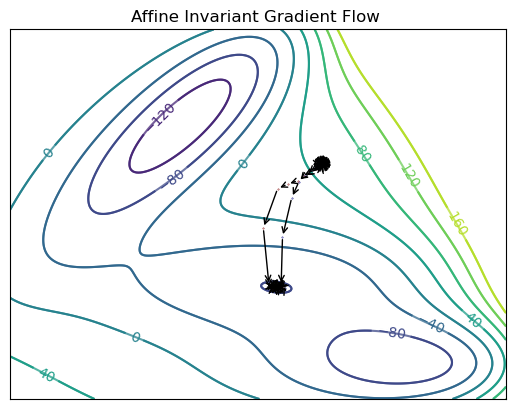

In [1360]:
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 2
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima = []
for j in tqdm(range(ntraj)):
    points_x, points_y, mean,C = affine_invariant_wd(N = 1000, learning_rate = 1e-2, mu = 0, sigma = 1e-3)
    minima.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                 arrowprops={'arrowstyle': '->',  'lw': 1},
                 va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Affine Invariant Gradient Flow ')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

(array([0.03108871, 0.        , 0.00843836, 0.01909735, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00088825]),
 array([-146.69936003, -129.89621442, -113.09306881,  -96.2899232 ,
         -79.48677759,  -62.68363198,  -45.88048637,  -29.07734075,
         -12.27419514,    4.52895047,   21.33209608]),
 <BarContainer object of 10 artists>)

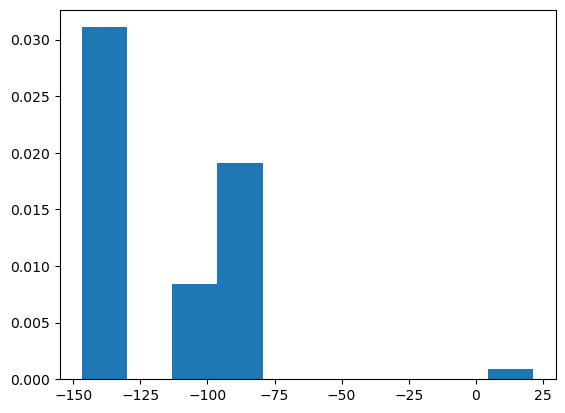

In [1292]:
bins = np.linspace(-150,10,5)
plt.hist(minima, density = 'True')

In [1472]:
# Training
def train(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    #initialise data
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    i = 1
    while 1<=i<=N+1:
        dx, dy = grad_MB(x,y)
        x1 = x - learning_rate*dx
        y1 = y - learning_rate*dy
        #err = np.abs(x1-x)+np.abs(y1-y)
        x = x1
        y = y1
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
        

    return points_x, points_y

def train_nesterov(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    i = 1
    
    while 1<=i<=N+1:
        dx, dy = grad_MB(u,v)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (i-1)/(i+2)*(x_new-x)
        v = y_new + (i-1)/(i+2)*(y_new-y)
        
        #err = np.abs(x_new-x)+np.abs(y_new-y)
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

def train_MaSS(intervals, N = 5000, learning_rate = 1e-3, a = 1, tolerance = 1e-2):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    u = x
    v = y
    i = 1
    count = 1
    
    while 1<=i<=N+1:
        dx, dy = grad_MB(u,v)
        
        m = 10
        eta2 = learning_rate/m
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (count-1)/(count+2)*(x_new-x) + eta2*dx
        v = y_new + (count-1)/(count+2)*(y_new-y) + eta2*dy
        
        if dx*(x_new-x)+dy*(y_new-y)>0: 
            count = 1
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

def train_sgd(intervals, N = 5000, learning_rate = 1e-3, a = 1, beta = 1, tolerance = 1e-2):
    #initialise data
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    err = np.inf
    i = 1
    while 1<=i<=N+1:
        dx, dy = grad_MB(x,y)
        x1 = x - learning_rate*dx + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        y1 = y - learning_rate*dy + np.sqrt(2/beta)*np.sqrt(learning_rate)*np.random.normal(0,1)
        x = x1
        y = y1
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
        
    return points_x, points_y

def train_MF_Hom_SGLD(intervals, N = 5000, learning_rate = 1e-3, M = 20, tolerance = 1e-2):
    
    #initialise data
    intervals = np.arange(1, 1e5, 20)
    #sample from data
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    points_x = []
    points_y = []
    
    Y_x = 0
    Y_y = 0
        
    i = 1
    
    while 1<=i<=N+1:
        
        #update Y
        Y_x_1 = Y_x
        Y_y_1 = Y_y
        
        cal_Y_x = 0
        cal_Y_y = 0
        
        for m in range(1,M+1):
            δ = 0.01/20
            γ = 0.05
            β = 0.1
            λ = 0.05
        
            dx, dy = grad_MB(Y_x_1,Y_y_1)
            
            Y_x_1 = Y_x_1 - δ*(dx-(1/γ)*(x-Y_x_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            Y_y_1 = Y_y_1 - δ*(dy-(1/γ)*(y-Y_y_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1)
            
            cal_Y_x += Y_x_1
            cal_Y_y += Y_y_1
            
        Y_x = Y_x_1
        Y_y = Y_y_1
        
        cal_Y_x /= M
        cal_Y_y /= M
        
        #update model parameters
        Δ = learning_rate
        mu = (x+y)/2
        
        x = x - 1/γ*(x-cal_Y_x)*Δ - λ*(x - mu)*Δ
        y = y - 1/γ*(y-cal_Y_y)*Δ - λ*(y - mu)*Δ
                
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    return points_x, points_y

def train_HJB(intervals, N = 5000, learning_rate = 1e-3, a = 1, L = 20, test = 'False'):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    u = x
    v = y
    
    #regularise potential 

    i = 1
    count = 1
    gamma_0 = 0.1
    gamma_1 = 1e-4
    gamma = gamma_0
    
    while 1<=i<=N+1:
        
        if i%L**2 == 0:
            gamma = gamma_0*(1-gamma_1)**(i/L)
        
        heat_x = np.random.normal(0,gamma,L)
        heat_y = gamma*np.random.normal(0,gamma,L)
        
        potential = np.exp(-vMB_potential(u+heat_x, v+heat_y))
        prob = potential/np.sum(potential)

        Dx, Dy = vgrad_MB(u+heat_x,v+heat_y)
        
        dx = np.sum(Dx*prob)
        dy = np.sum(Dy*prob)
        
        x_new = u - learning_rate*dx
        y_new = v - learning_rate*dy
        
        u = x_new + (count-1)/(count+2)*(x_new-x)
        v = y_new + (count-1)/(count+2)*(y_new-y)
        
        if dx*(x_new-x)+dy*(y_new-y)>0: 
            count = 1
        
        x = x_new
        y = y_new
        
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            if test == 'True':
                print('Epoch: {}'.format(i))
                print('x: {}'.format(x))
                print('y: {}'.format(y))
            
        i+=1
    
    return points_x, points_y

def train_HGD(intervals, N = 5000, learning_rate = 1e-4, a = 1, L = 20):
    intervals = np.arange(1, 1e5, 20)
    points_x = []
    points_y = []
    x = np.random.uniform(-1.5, 1.2)
    y = np.random.uniform(-0.2, 2)
    
    i = 1
    
    gamma_0 = 0.3
    gamma_1 = 1e-1
    gamma = gamma_0
    
    while 1<=i<=N+1:
        if i%L**2 == 0:
            gamma = gamma_0*(1-gamma_1)**(i/L**2)
            

        heat_x = gamma*np.random.normal(0,1,L)
        heat_y = gamma*np.random.normal(0,1,L)
        
        potential = np.exp(-vMB_potential(x+heat_x, y+heat_y))
        prob = potential/np.sum(potential)

        Dx, Dy = vgrad_MB(x+heat_x,y+heat_y)
        
        dx = np.sum(Dx*prob)
        dy = np.sum(Dy*prob)
        
        x -= learning_rate*dx
        y -= learning_rate*dy
    
        if i in intervals:
            points_x.append(x)
            points_y.append(y)
            '''
            print('Epoch: {}'.format(i))
            print('x: {}'.format(x))
            print('y: {}'.format(y))
            '''
        i+=1
    
    return points_x, points_y

  0%|          | 0/10 [00:00<?, ?it/s]

([], [])

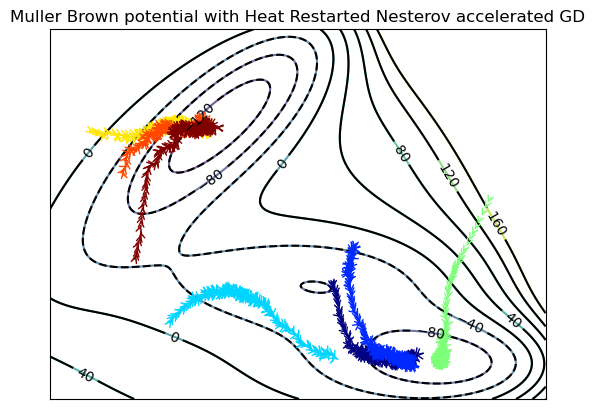

In [1473]:
#Heat Restarted Nesterov with HJB regularised Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 10
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_HJB = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_HJB(intervals, learning_rate = 1e-5, a = 1)
    minima_HJB.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6: 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x)-1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with Heat Restarted Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

(array([1., 0., 1., 0., 1., 0., 0., 0., 2., 3., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-150., -145., -140., -135., -130., -125., -120., -115., -110.,
        -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,  -70.,  -65.,
         -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,  -25.,  -20.,
         -15.,  -10.,   -5.,    0.,    5.]),
 <BarContainer object of 31 artists>)

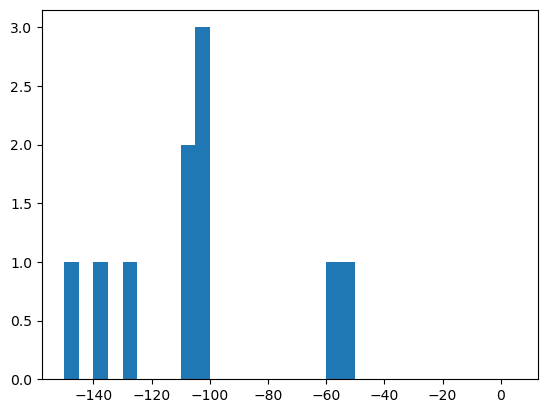

In [1474]:
bins = np.arange(-150, 10, 5)
plt.hist(minima_HJB, bins = bins)

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

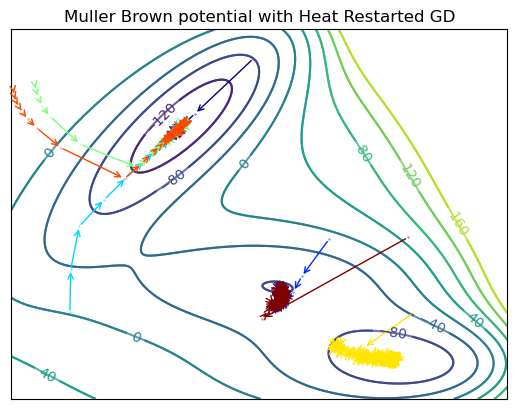

In [848]:
#Heat Restarted GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_HGD = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_HGD(intervals, learning_rate = 1e-4, a = 1)
    minima_HGD.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with Heat Restarted GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

In [696]:
#Vanilla GD
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_vanilla = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train(intervals, learning_rate = 1e-4, a = 1, tolerance = 1e-5)
    minima_vanilla.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6 : 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j], 'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with vanilla GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

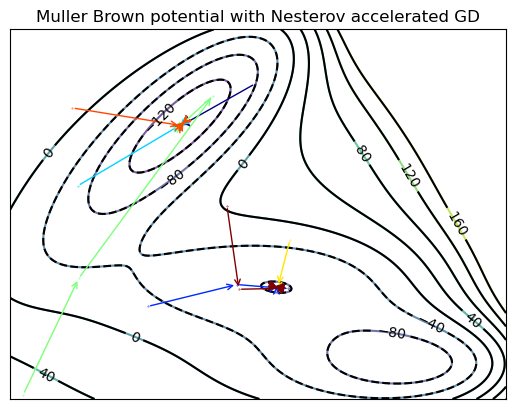

In [617]:
#Nesterov Potential 
n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_nesterov = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_nesterov(intervals, learning_rate = 1e-4, a = 1, tolerance = 1e-5)
    minima_nesterov.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6: 
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x)-1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8)
plt.title('Muller Brown potential with Nesterov accelerated GD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

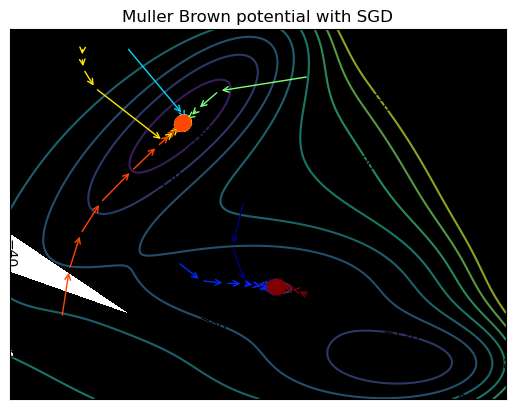

In [628]:
#sgd

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_sgd = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_sgd(intervals, learning_rate = 1e-4, a = 1, beta = 100, tolerance = 1e-5)
    minima_sgd.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with SGD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

([], [])

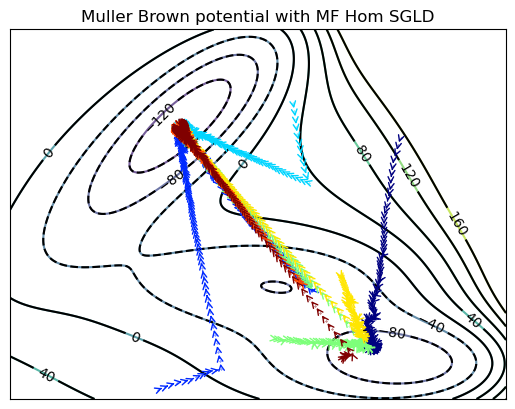

In [625]:
#MF Hom SGLD

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 1000
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_MF_Hom_SGLD = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_MF_Hom_SGLD(intervals, learning_rate = 1e-4, M = 20)
    minima_MF_Hom_SGLD.append(MB_potential(points_x[-1],points_y[-1]))
    if j <=6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with MF Hom SGLD')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

([], [])

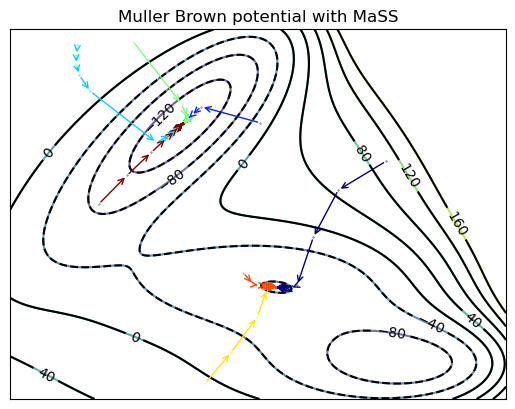

In [602]:
#MaSS

n = 256
x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

intervals = np.arange(1, 1e5, 20)

ntraj = 20
colors = plt.cm.jet(np.linspace(0,1,np.minimum(ntraj, 7)))# Initialize holder for trajectories
minima_MaSS = []
for j in tqdm(range(ntraj)):
    points_x, points_y = train_MaSS(intervals, learning_rate = 1e-4, a = 1)
    minima_MaSS.append(MB_potential(points_x[-1],points_y[-1]))
    if j <= 6:
        plt.scatter(points_x, points_y, color = colors[j], s = 0.1)
        for i in range(len(points_x) - 1):
            plt.annotate('', xy =[points_x[i+1], points_y[i+1]], xytext= [points_x[i], points_y[i]],
                         arrowprops={'arrowstyle': '->', 'color': colors[j],  'lw': 1},
                         va='center', ha='center')

plt.contour(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.title('Muller Brown potential with MaSS')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])
#plt.legend()

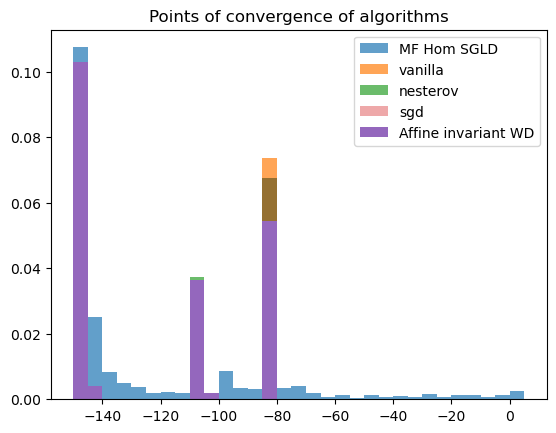

In [1273]:
bins = np.arange(-150, 10, 5)
plt.title('Points of convergence of algorithms')
plt.hist(minima_MF_Hom_SGLD, alpha = 0.7, bins = bins, density = 'True', label = 'MF Hom SGLD')
plt.hist(minima_vanilla, alpha = 0.7, density = 'True', bins = bins, label = 'vanilla')
plt.hist(minima_nesterov, alpha = 0.7, density = 'True',bins = bins, label = 'nesterov')
#plt.hist(minima_HGD, alpha = 0.7, density = 'True', label = 'HGD')
plt.hist(minima_sgd, alpha = 0.4, density = 'True', bins = bins, label = 'sgd')
plt.hist(minima, density = 'True', bins = bins, label = 'Affine invariant WD')
plt.legend()

In [ ]:
#contour plot of Muller-Brown potential 
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

def reg_potential(x,y):
    gibbs = 0
    L = 10
    noise_x = np.random.normal(0,0.4, L)
    noise_y = np.random.normal(0,0.4, L)
    gibbs = np.mean(np.exp(-vMB_potential(x+noise_x,y+noise_y)))
        
    return -np.log(gibbs)
vreg_potential = np.vectorize(reg_potential)

Z = vreg_potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(0, 90)
plt.contour(X, Y, Z.clip(max = 200), 500, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

/var/folders/vk/rhw_l1h57sl1rcs8qwgx9tvm0000gn/T/ipykernel_39128/1689129583.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.log(gibbs)


Text(0, 0.5, 'y')

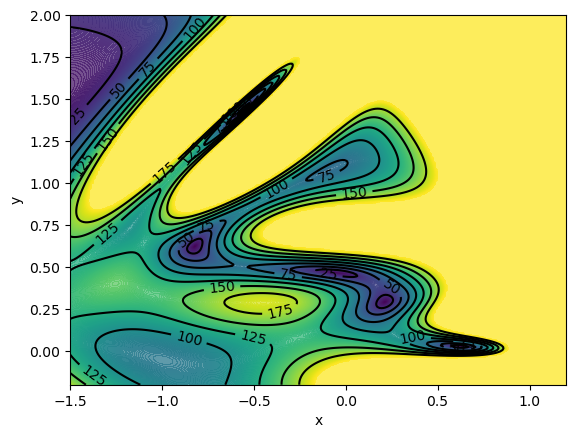

In [794]:
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

Z = (vgrad_MB(X, Y)[0]**2+vgrad_MB(X, Y)[1]**2)**(0.5)

plt.contourf(X, Y, Z.clip(max = 200), 500, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, Z.clip(max = 200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

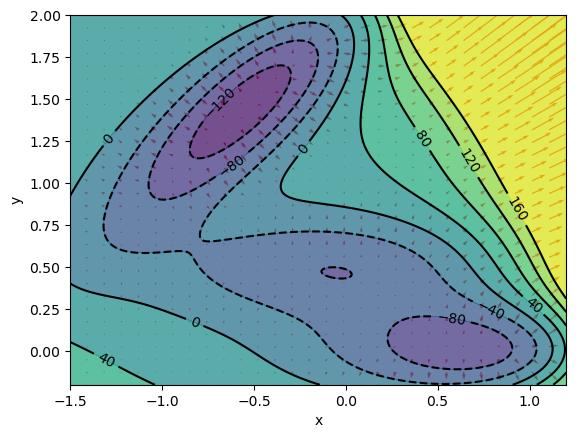

In [791]:
n = 256

x = np.linspace(-1.5, 1.2, n)
y = np.linspace(-0.2, 2, n)
X, Y = np.meshgrid(x, y)

x1 = np.linspace(-1.5, 1.2, 30)
y1 = np.linspace(-0.2, 2, 30)
X1, Y1 = np.meshgrid(x1, y1)
U, V = vgrad_MB(X1, Y1)

plt.quiver(X1,Y1,U,V, color = 'red')
plt.contourf(X, Y, vMB_potential(X, Y).clip(max=200), 8, alpha=.75, cmap='viridis')
C = plt.contour(X, Y, vMB_potential(X,Y).clip(max=200), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xlabel('x')
plt.ylabel('y')

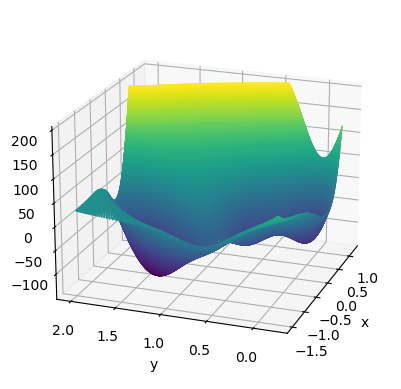

In [1384]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 200)
Z = vMB_potential(X,Y)
plt.contour(X, Y, Z.clip(max=200), 1000, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# General Observations:
- Most algorithms on the MB potential get stuck equally on two local minima, i.e. the global one (which is narrow) and the one with the next smallest local minimum
- Convolving with a solution to the heat equation does not improve performance as the narrow steep global minimum (as seen from the plot) is smeared out first thus giving no hope of real convergence, unless the algorithms is lucky with the initialisation
- The Hom-MF-SGLD works surprisingly well against all others since it performs a gradient flow of a regularised potential, where regularisation is done at the level of the gibbs measure
- Idea, maybe sample points (to initialise GD) more judiciously, i.e. with gibbs measure (inspired by Andrew Stuart's paper ) by performing a gradient flow and use that 'educated guess as the initialisation of a gd algorithm. (e.g. Wasserstein gradient flow, i.e. sgd on log of Gibbs measure of potential, or affine invariant Wasserstein)
- This idea seems to perform better that all algorithms except the MF-Hom-SGLD algorithm
- Regularising using the HJB equation (essentially performed in the MF-Hom_SGLD algorithm) is better suited to minima that are narrower compared to regularisation with the heat equation that destroys such peaks first (due to large curvature)
- Tried regularising wrt soln of HJB equation directly and apply nesterov's accelerated gd algorithm with gradient restarting